In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd

## Data, data, data -- so much data!

The data consists of thousands of images (.png files) of plankton taken using a Flow Cytometer (ADD REF). Each plankton image has been classified by an expert. The data is organised into directories for each, each containing subdirectories for each class. First, let's read through the directories to list all the classes in the dataset.

In [2]:
data_dir="/dat1/smart1n/phytoplankton classifier/" 

In [3]:
def png_filenames(year,data_dir):
    
    dir_name=data_dir + str(year) + '/'

    a=!find  "{dir_name}" -name "*.png"   # use a linux command to find all png files in the folder; it returns a list with paths of *png files
    
    a=np.array(a)                         # make the list into an numpy array for more convenient operations


    exclude_list=np.array(['mix','mix_elongated','detritus','bad']) # define a set of phytoplankton classes to exclude from data

    class_name=a.copy();
    
    for i in range(len(a)):
        class_name[i]=a[i].replace(dir_name,'').split('/', 1)[0]    # use the path name to extract the class. The images are organized in folders as /year/class_name/*.png
        if np.sum(exclude_list==class_name[i]):
            class_name[i]="";

    a=a[class_name!=""]                        # remove the empty data from excluded classes
    class_name=class_name[class_name!=""]    
    
    return a, class_name                       # return pathnames and class_name

In [4]:
#extract png file paths for a range of years

class_name=np.array([])
png_names=np.array([])
for year in np.arange(2006, 2010):
        print(year)
        a, b = png_filenames(year,data_dir)
        png_names=np.concatenate((png_names, a), axis=0)    #concatenate the data from different years
        class_name=np.concatenate((class_name, b), axis=0)

2006
2007
2008
2009


In [5]:
classes, counts = np.unique(class_name, return_counts=True)               # identify the unique classes and associated number of examples 
classes_sorted=[x for y, x in sorted(zip(counts,classes),reverse=True)]   # sort classes by the number of examples 
counts_sorted=sorted(counts,reverse=True)

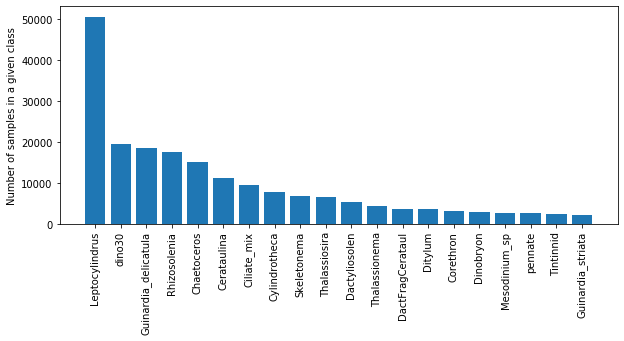

In [6]:
plt.figure(figsize=(10,4))
plt.bar(classes_sorted[:20], counts_sorted[:20]) #plot top 10 most observed classes
plt.xticks(rotation='vertical')
plt.ylabel('Number of samples in a given class');

In [7]:
#crop only the center n by n pixel image from the original data, and fill the image to an n by n size if it is smaller than that
def crop_center(im,n):
    
    nx=im.shape[1]
    ny=im.shape[0]

    if nx<n:
        imm=np.zeros((ny,n))
        imm[:ny,:nx]=im
        im=imm
    
    nx=im.shape[1]
    ny=im.shape[0]
    
    if ny<n:
        imm=np.zeros((64,nx))
        imm[:ny,:nx]=im
        im=imm
        
    nx=im.shape[1]
    ny=im.shape[0]
    
    im=im[ (ny//2-n//2):(ny//2+n//2),(nx//2-n//2):(nx//2+n//2)]

    return im

Now, let's try loading in some of the images and taking a look at them:

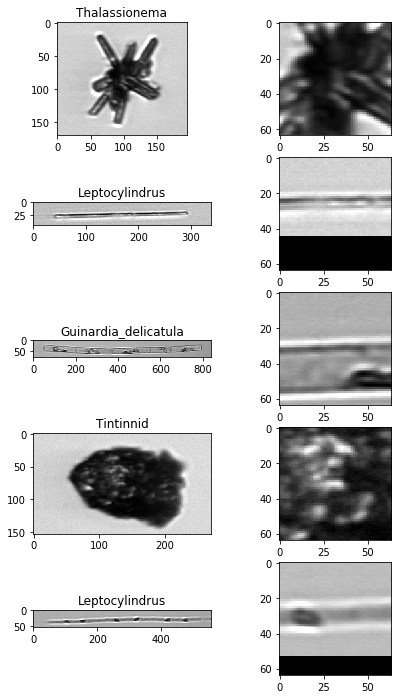

In [8]:
fig, axs = plt.subplots(5,2, figsize = (7,12))
for i in range(5):
    N=np.random.randint(len(png_names))
    im=image.imread(png_names[N])
    axs[i][0].imshow(im, cmap = 'gray')
    im=crop_center(im,64)
    axs[i][1].imshow(im, cmap = 'gray')
    axs[i][0].set_title(class_name[N]);

As you can see, the images come in very different shapes and sizes. This is a problem for us, as our CNN classifier will require the images to have a fixed size. To get around this, let's split each image up into smaller square crops of equal size. This way, the CNN won't see the whole plankton at once, instead it will have to learn to recognise classes by seeing small segments.

Let's do this to the first Akashiwo image as an example:

Each of these smaller square images will have the class label: Akashiwo. So the CNN will have to learn to recognise textures in the smaller images that determine the class.

Note that some of the edge images are empty. This is a problem for us as there will be lots of empty images with different class labels since there are large empty borders in many of the images. Avoiding any of these making it into the dataset is hard, but we can try a crude method for reducing the number of them, we'll see that a little later.

Now that we've explored the data a little, let's go ahead and load in lots of images (extracting square crops from each) into a pandas dataframe.

In [9]:
def load_images(a,class_name,keep_classes):
    
    print('Loading the following classes:', keep_classes);
    class_name_keep=class_name.copy()
    
    a_keep=a.copy()

    for i in range(len(a)):
        if np.sum(keep_classes==class_name_keep[i])==0:
            class_name_keep[i]="";

    a_keep=a_keep[class_name_keep!=""]
    class_name_keep=class_name_keep[class_name_keep!=""]
    
    
    Nsamples=len(a_keep)
    IMAGES=np.zeros((Nsamples,64,64))
    IM_class=class_name_keep.copy()
    
    for i in range(Nsamples):
        im=image.imread(a[i])
        IMAGES[i,:,:]=crop_center(im,64)
        
        
    class_labels=np.arange(len(IM_class))
    for i in range(len(keep_classes)):
        class_labels[IM_class==keep_classes[i]]=i    
    
    return IMAGES, IM_class, class_labels

Even with this smaller set of classes, there is a large 'class imbalance' (i.e. there are many more examples of some classes than of others). A CNN trained on this dataset is likely to perform poorly in classifying the least frequently occuring class, as it will have 'seen' fewer examples compared to the other classes. There are a number of ways to deal with class imbalance (ADD REF), here we'll use 'undersampling'. This means we'll remove samples from the frequently occuring classes until all classes have the same number of samples as the least frequently occuring, thus creating a smaller but balanced data set. 

In [10]:
def balance_class_samples(png_names,class_name,keep_classes):
    
    n_min=np.sum(class_name==keep_classes[-1])
    
#    n_min=1000;

    png_names_balanced=np.array([])
    class_name_balanced=np.array([])

    for i in range(len(keep_classes)):
        png_names_i=png_names[class_name==keep_classes[i]]
        class_name_i=class_name[class_name==keep_classes[i]]

        rand_ind=np.random.randint(0,len(png_names_i),n_min);
        rand_ind=np.sort(rand_ind)
#        rand_ind=np.arange(n_min)

        png_names_i=png_names_i[rand_ind]
        class_name_i=class_name_i[rand_ind]

        png_names_balanced=np.concatenate((png_names_balanced, png_names_i), axis=0)
        class_name_balanced=np.concatenate((class_name_balanced, class_name_i), axis=0)
        
    return png_names_balanced,class_name_balanced

In [11]:
%%time

keep_classes=np.array(classes_sorted[:10])

png_names_balanced,class_name_balanced =balance_class_samples(png_names,class_name,keep_classes)

IMAGES, IM_class, class_labels = load_images(png_names_balanced,class_name_balanced,keep_classes)

Loading the following classes: ['Leptocylindrus' 'dino30' 'Guinardia_delicatula' 'Rhizosolenia'
 'Chaetoceros' 'Cerataulina' 'Ciliate_mix' 'Cylindrotheca' 'Skeletonema'
 'Thalassiosira']
CPU times: user 32.6 s, sys: 6.47 s, total: 39.1 s
Wall time: 3min 36s


# Deep Learning

Now that we have the desired data loaded in an appropriate format, it's time to design a deep neural network. We will explore Convolutional Neural Networks, wich are some of the most powerful neural network architectures for analysis of images.

In [13]:
X= np.expand_dims(IMAGES, axis=3)
# create the one-hot encoding of the training labels
Y = keras.utils.to_categorical(class_labels, len(keep_classes))

In [49]:
# define a simple CNN model to classify plankton types
def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)
    
    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)
    
    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y) # apply dropout to prevent overfitting
    
    y = keras.layers.Dense(output_shape, activation='softmax')(y)     # add final output layer with a softmax activation
    
    model = keras.models.Model(inputs=x, outputs=y)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
CNN = create_cnn_model(input_shape=(64,64,1), output_shape=len(keep_classes))
CNN.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0   

In [58]:
%%time 

val_split=0.2

ind_val= (np.random.rand(X.shape[0])<val_split)

X_val=X[ind_val]
Y_val=Y[ind_val]

class_labels_val=class_labels[ind_val]

X_train=X[~ind_val]
Y_train=Y[~ind_val]


hist = CNN.fit(x = X_train, y = Y_train, epochs=20, batch_size=512, validation_data=(X_val,Y_val))

Train on 51895 samples, validate on 12785 samples
Epoch 1/20
51895/51895 [==============================] - 4s 76us/sample - loss: 1.9518 - accuracy: 0.2419 - val_loss: 1.6380 - val_accuracy: 0.3758
Epoch 2/20
51895/51895 [==============================] - 3s 57us/sample - loss: 1.4936 - accuracy: 0.4235 - val_loss: 1.2863 - val_accuracy: 0.5032
Epoch 3/20
51895/51895 [==============================] - 3s 51us/sample - loss: 1.2803 - accuracy: 0.5151 - val_loss: 1.1238 - val_accuracy: 0.5708
Epoch 4/20
51895/51895 [==============================] - 3s 53us/sample - loss: 1.1695 - accuracy: 0.5639 - val_loss: 1.0276 - val_accuracy: 0.6242
Epoch 5/20
51895/51895 [==============================] - 3s 56us/sample - loss: 1.0889 - accuracy: 0.6000 - val_loss: 0.9685 - val_accuracy: 0.6461
Epoch 6/20
51895/51895 [==============================] - 3s 55us/sample - loss: 1.0264 - accuracy: 0.6251 - val_loss: 0.9291 - val_accuracy: 0.6601
Epoch 7/20
51895/51895 [==============================] 

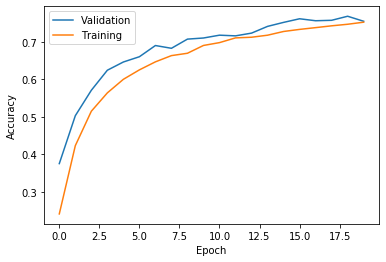

In [59]:
plt.plot(hist.history['val_accuracy'],label='Validation')
plt.plot(hist.history['accuracy'],label='Training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

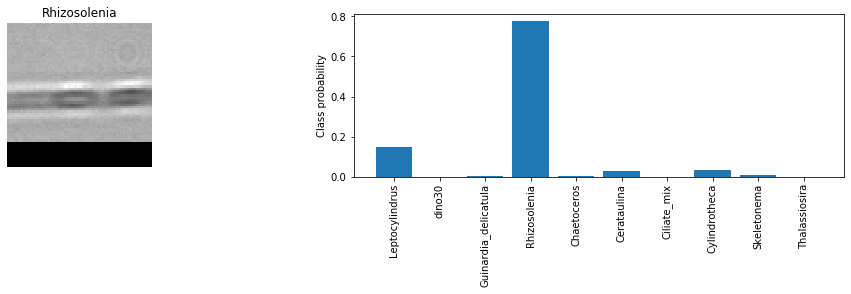

In [63]:
N=np.random.randint(0,X_val.shape[0]) # test some random image

x=np.expand_dims(X_val[N], axis=0)
predictions = CNN.predict(x)

class_name_true=keep_classes[Y_val[N,:]==1][0]

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.imshow(x[0,:,:,0], cmap = 'gray', vmin = 0, vmax = 1)
plt.title(class_name_true)
plt.axis('off')

plt.subplot(1,5,(3,5))
plt.bar(keep_classes,predictions[0])
plt.xticks(rotation='vertical')
plt.ylabel('Class probability');
ax=plt.gca()
ax.grid(False)


## Metrics of accuracy: confusion matrix

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
predictions = CNN.predict(X_val)
predictions_class=np.argmax(predictions, axis=1)

In [66]:
conf_mat=confusion_matrix(class_labels_val, predictions_class)

conf_mat=conf_mat/ conf_mat.astype(float).sum(axis=1, keepdims=True); # normalizing by the total number of sambles;
conf_mat=(conf_mat*100).astype(int)  # in per cent now, which is good for plotting!

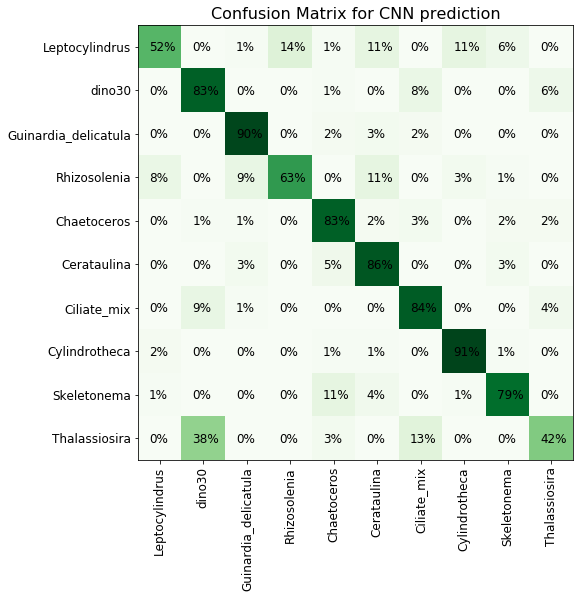

In [67]:
n=len(keep_classes)

plt.figure(figsize=(8,8))
plt.imshow(conf_mat, cmap='Greens',aspect=1)
ax=plt.gca()
plt.xticks(range(n), keep_classes, rotation='vertical',fontsize=12)
plt.yticks(range(n), keep_classes, fontsize=12);
ax.grid(False)
plt.title('Confusion Matrix for CNN prediction',fontsize=16)
for i in range(n):
    for j in range(n):
        plt.text(i-0.25,j+0.1, str(conf_mat[j,i])+'%', fontsize=12);